In [16]:
import pandas as pd
df = pd.read_parquet('bert_embeddings_balanced.parquet')

In [17]:
df.head()

,bert1,bert2,bert3,bert4,bert5,bert6,bert7,bert8,bert9,bert10,...,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767,bert768,label
1,-0.736354,-0.452857,-0.900266,0.607368,0.529110,-0.267249,0.433341,0.334155,-0.490231,-0.999952,...,0.077231,0.879335,0.622733,-0.110044,0.129889,0.536032,-0.797028,-0.599843,0.759636,0
9,-0.744532,-0.458835,-0.744694,0.532082,0.311149,-0.129973,0.472880,0.302928,-0.515092,-0.999948,...,0.256472,0.768397,0.710780,0.346100,0.227118,0.615897,-0.566250,-0.635862,0.742113,0
19,-0.703188,-0.482237,-0.837993,0.409060,0.359978,-0.125014,0.141701,0.312893,-0.582415,-0.999898,...,0.357343,0.813748,0.582983,0.249468,-0.001338,0.718755,-0.735795,-0.579613,0.611509,0
20,-0.796584,-0.525187,-0.901323,0.721053,0.615162,-0.146203,0.736815,0.410643,-0.672798,-0.999979,...,-0.195539,0.913168,0.737932,-0.083464,0.204053,0.676939,-0.717710,-0.695663,0.880075,0
28,-0.709045,-0.550619,-0.848802,0.587083,0.369470,-0.166272,0.443767,0.466523,-0.492669,-0.999962,...,-0.386924,0.813545,0.633295,0.182253,0.055231,0.687205,-0.530302,-0.657097,0.604088,0


Dane po balansowaniu nie są losowo rozłożone (patrz kolumna 'label'). Należy nadać im losowe indeksy.

In [18]:
df = df.sample(frac=1)
df.head()

,bert1,bert2,bert3,bert4,bert5,bert6,bert7,bert8,bert9,bert10,...,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767,bert768,label
40428,-0.900207,-0.858093,-0.999552,0.951810,0.978555,-0.666642,0.888924,0.771945,-0.997602,-0.999996,...,-0.918697,0.999845,0.763656,-0.887841,-0.906582,0.884986,-0.994873,-0.848654,0.773525,1
52856,-0.837857,-0.485915,-0.855531,0.718861,0.558431,-0.131904,0.825269,0.303029,-0.633303,-0.999990,...,0.093617,0.892855,0.861811,0.160188,0.280495,0.658240,-0.660138,-0.730824,0.861710,0
64693,-0.702793,-0.678349,-0.992216,0.691039,0.934006,-0.393426,0.218740,0.493702,-0.973966,-0.999924,...,-0.833017,0.997146,0.483174,-0.726870,-0.472713,0.802418,-0.972553,-0.639424,0.382296,1
30995,-0.590060,-0.339252,-0.489177,0.391528,-0.006431,-0.048762,0.457048,0.280570,-0.100246,-0.999845,...,0.157101,0.407503,0.612711,0.398827,0.280223,0.661007,-0.379351,-0.549560,0.630251,1
16168,-0.724947,-0.547347,-0.933619,0.641647,0.665955,-0.252650,0.549116,0.330619,-0.722460,-0.999983,...,-0.327987,0.940855,0.617321,-0.191509,0.006916,0.792533,-0.871150,-0.655166,0.731440,0


Zbiór dzielony jest na część treningową oraz przeznaczoną na symulację data-stream

In [28]:
df_training = df.sample(frac=0.5, random_state=42)
df_drift = df.drop(index=df_training.index, axis=0)

print(df_training.index == df_drift.index)
print(len(df_training), len(df_drift))

[False False False ... False False False]
25220 25220


In [57]:
df_training.shape

(25220, 769)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm

In [56]:
n = [5, 10, 100, 500, 1000, 2000]

rf = [RandomForestClassifier(n_estimators=i) for i in n]

scoring = {
    'f1' : make_scorer(f1_score),
    'accuracy' : make_scorer(accuracy_score),
    'precision_score' : make_scorer(precision_score),
    'recall_score' : make_scorer(recall_score)
}

# X_train, y_train  = df_training.drop(columns=['label']).iloc[:1000], df_training['label'].iloc[:1000]
X_train, y_train  = df_training.drop(columns=['label']), df_training['label']

scores = []
for i in tqdm(range(len(n))):
    scores.append(cross_validate(rf[i], X=X_train, y=y_train, scoring=scoring, cv=5, return_train_score=True, n_jobs=-1))

100%|██████████| 6/6 [37:03<00:00, 370.61s/it]


In [81]:
scores_means = []
for score in scores: scores_means.append(pd.DataFrame(score).mean())

In [83]:
df_scores = pd.DataFrame(scores_means)
df_scores['n_estimators'] = n
df_scores.set_index('n_estimators')

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision_score,train_precision_score,test_recall_score,train_recall_score
n_estimators,,,,,,,,,,
5,2.430421,0.018708,0.930858,0.993242,0.930967,0.993249,0.930617,0.992544,0.931119,0.993942
10,4.722051,0.019781,0.937852,0.997584,0.938898,0.997591,0.952337,0.998845,0.923810,0.996326
100,59.650957,0.092232,0.956858,0.999811,0.956860,0.999812,0.955120,0.999682,0.958608,0.999940
500,297.275497,0.367221,0.958880,0.999811,0.958842,0.999812,0.956237,0.999682,0.961547,0.999940
1000,580.937432,0.813457,0.959278,0.999811,0.959199,0.999812,0.955694,0.999682,0.962898,0.999940
2000,1158.765755,1.351178,0.959059,0.999811,0.958961,0.999812,0.955028,0.999682,0.963136,0.999940


In [94]:
df_results = df_scores.drop(columns=['train_f1', 'train_accuracy', 'train_precision_score', 'train_recall_score']).set_index('n_estimators')
df_results

,fit_time,score_time,test_f1,test_accuracy,test_precision_score,test_recall_score
n_estimators,,,,,,
5,2.430421,0.018708,0.930858,0.930967,0.930617,0.931119
10,4.722051,0.019781,0.937852,0.938898,0.952337,0.923810
100,59.650957,0.092232,0.956858,0.956860,0.955120,0.958608
500,297.275497,0.367221,0.958880,0.958842,0.956237,0.961547
1000,580.937432,0.813457,0.959278,0.959199,0.955694,0.962898
2000,1158.765755,1.351178,0.959059,0.958961,0.955028,0.963136


In [108]:
with open('random_forest_cross_val_table.txt', '+w') as file:
    file.write(df_results.to_latex())

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_training.drop(columns=['label']), df_training['label'], test_size = 0.3, shuffle=True, random_state=42)

In [156]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [157]:
import pickle
with open('RandomForest_model.pickle', 'wb') as file:
    pickle.dump(rf_model, file)

In [158]:
y_pred = rf_model.predict(X_test)

def final_model_results(y_test, y_pred):
    results = {
    'estimators' : [100],
    'accuracy' : [accuracy_score(y_test, y_pred)],
    'precision' : [precision_score(y_test, y_pred)],
    'recall' : [recall_score(y_test, y_pred)],
    'f1 score' : [f1_score(y_test, y_pred)]
    }
    results_df = pd.DataFrame(results).set_index('estimators')
    return results_df

df_final_model_results = final_model_results(y_test, y_pred)

with open('random_forest_final_table.txt', 'w+') as file:
    file.write(df_final_model_results.to_latex())
    
df_final_model_results

,accuracy,precision,recall,f1 score
estimators,,,,
100,0.953873,0.949243,0.957641,0.953423


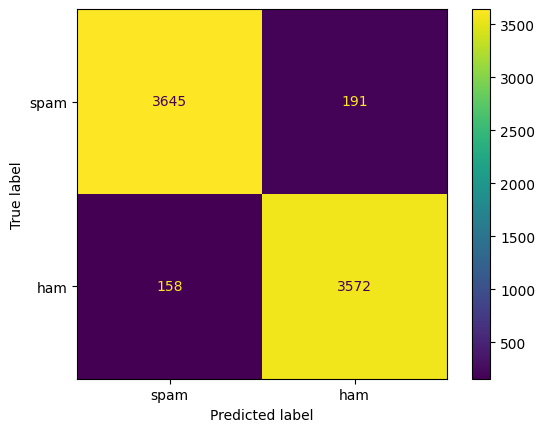

In [159]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['spam', 'ham'])
disp.plot()
plt.savefig('random_forest_confusion_matrix.png')
plt.show()

## Data-stream
1. Wczytanie nowych danych i wytrenowanego wcześniej modelu

In [166]:
X_train_drift, X_test_drift, y_train_drift, y_test_drift = train_test_split(df_drift.drop(columns=['label']), df_drift['label'], test_size = 0.5, shuffle=True, random_state=42)

with open('RandomForest_model.pickle', 'rb') as file:
    new_model = pickle.load(file)

new_model

RandomForestClassifier(random_state=42)

2. Klasyfikacja z wykorzystaniem pierwotnego modelu

In [162]:
y_pred_drift = new_model.predict(X_test_drift)
final_model_results(y_test_drift, y_pred_drift)

,accuracy,precision,recall,f1 score
estimators,,,,
100,0.959635,0.959891,0.958819,0.959355


3. Uczenie modelu na nowych danych

In [164]:
new_model.fit(X_train_drift, y_train_drift)

RandomForestClassifier(random_state=42)

4. Klasyfikacja przez "douczony" model

In [165]:
y_pred_tuned = new_model.predict(X_test_drift)
final_model_results(y_test_drift, y_pred_tuned)

,accuracy,precision,recall,f1 score
estimators,,,,
100,0.954084,0.952131,0.955626,0.953876
